# Calculo del cociente espectral HV

In [1]:
import obspy  
import numpy as np
from scipy.signal import windows
import matplotlib.pyplot as plt
from numpy.fft import fft
import pandas as pd

## Lectura del archivo de parámetros

Se carga un archivo de texto con los paramatros requeridos para el procesamiento.


| Parámetro | Valor de ejemplo | Descripción |
|------------|------------------|--------------|
| **Duración LTA** | `25` | Longitud de la ventana LTA (*Long-Term Average*), usada para calcular el promedio a largo plazo de la señal. |
| **Duración STA** | `2` | Longitud de la ventana STA (*Short-Term Average*), usada para calcular el promedio a corto plazo. |
| **Umbral mínimo STA/LTA (bajo)** | `0.2` | Umbral mínimo del cociente STA/LTA para detectar el inicio de un evento. |
| **Umbral mínimo STA/LTA (alto)** | `2` | Segundo valor de umbral STA/LTA; puede representar una condición superior o alternativa de detección. |
| **Duración mínima de ventana seleccionada** | `32` | Duración mínima (en segundos o muestras) de las ventanas válidas para el análisis. |
| **Tipo de ventana** | `0` | Define si las ventanas son de **longitud fija (0)** o **variable (1)**. |
| **Duración máxima (si variable)** | `40` | Longitud máxima permitida para ventanas de longitud variable. |
| **Porcentaje de solapamiento entre ventanas** | `0` | Porcentaje de recubrimiento entre ventanas consecutivas. `0` significa que no hay solapamiento. |
| **Tipo de suavizado espectral (FFT)** | `1` | Tipo de suavizado aplicado al espectro antes del cálculo H/V. `1` indica suavizado **Konno-Ohmachi**. |
| **Parámetro b del suavizado Konno-Ohmachi** | `40` | Controla el grado de suavizado: valores mayores producen un suavizado más estrecho. |
| **Criterio de selección de ventanas** | `1` | `0`: selección independiente por componente. `1`: selección basada en la media cuadrática de las tres componentes. |
| **Frecuencia de corte del sensor (Hz)** | `0.5` | Frecuencia de corte o límite inferior de respuesta del sensor. |
| **Factor de decimación de los datos** | `1` | Indica el grado de reducción de muestreo. `1` significa que no hay decimación. |
| **Frecuencia máxima de salida (Hz)** | `30` | Frecuencia máxima considerada o guardada en el archivo de salida. |

In [ ]:
lta = 25.0   # Length (s) for the Long-Term Average (LTA)
sta = 2.0    # Length (s) for the Short-Term Average (STA)
seuilmin = 0.2  # Minimum threshold for the STA/LTA ratio
seuilmax = 2.0  # Maximum threshold for the STA/LTA ratio
tmin = 32.0     # Minimum window length to select (s)
tmax = 40.0     # Maximum window length (if variable lengths are used)
tvar = 0.0      # Time window for the trigger (s)
overlap = 0.0   # Percentage of overlap between two consecutive windows
trig_var = 1    # Select windows simultaneously on the 3 components (0) or on the RMS of the 3 components (1)
lis_typ = 1    # Type of smoothing: Konno-Ohmachi (1) or moving average (2)
lis_var = 40  # Smoothing parameter (bandwidth for Konno-Ohmachi, window length for moving average)
fsensor = 0.5 # Sensor corner frequency (Hz); 0.5 Hz for Lennartz 3D/5s
fmax =  30   # Maximum frequency for H/V computation (Hz)

## Lectura de los archivos de datos sísmicos

Extrae los nombres de los archivos que se usaran para el análisis y define la carpeta de destino de los resultados.

In [3]:
data_E = obspy.read("00P2-2_WA.WAU40..HHE.D.2020.281.sac", format="SAC")[0].data # east-west component
data_N = obspy.read("00P2-2_WA.WAU40..HHN.D.2020.281.sac", format="SAC")[0].data # north-south component
data_Z = obspy.read("00P2-2_WA.WAU40..HHZ.D.2020.281.sac", format="SAC")[0].data # vertical component
data_times = obspy.read("00P2-2_WA.WAU40..HHE.D.2020.281.sac", format="SAC")[0].times() # in seconds
data = np.column_stack((data_Z, data_N, data_E)) # combine the three components into a single array
fs = 1 / (data_times[1] - data_times[0]) # sampling frequency

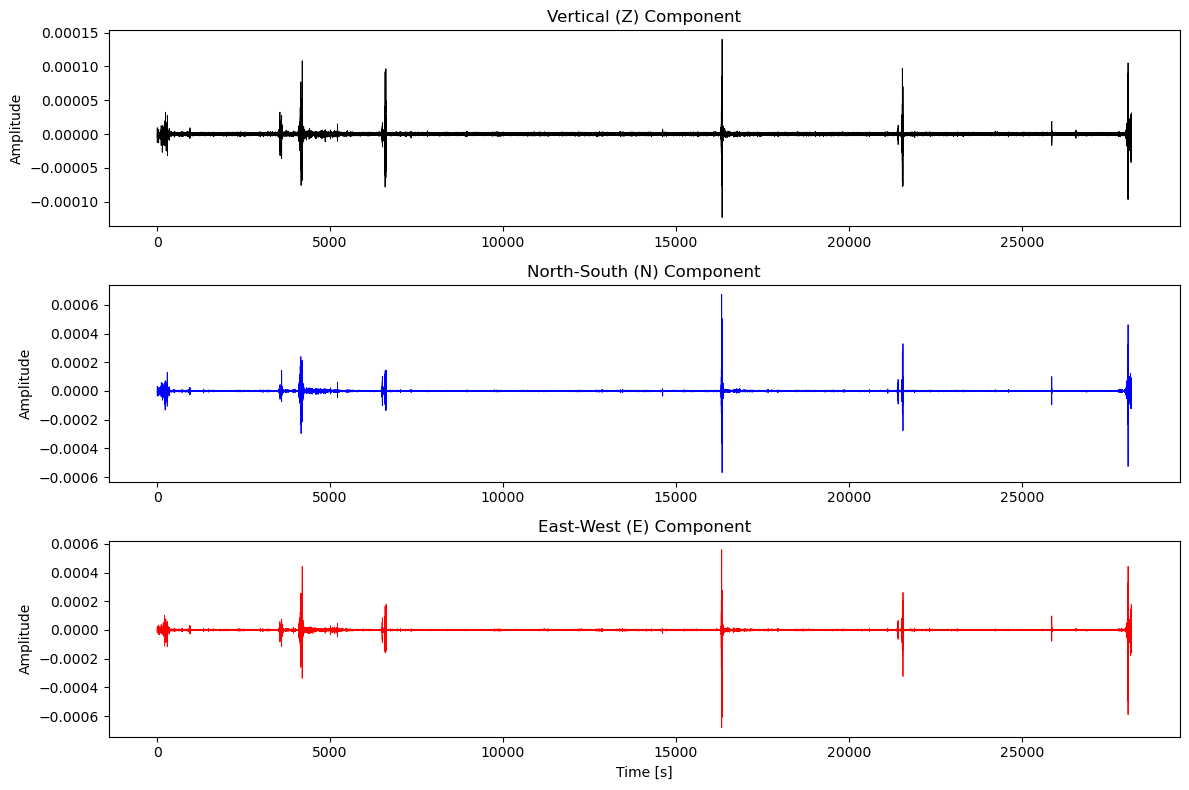

In [4]:
# --- Plot the three components ---
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(data_times, data_Z, color='black', linewidth=0.6)
plt.title("Vertical (Z) Component")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(data_times, data_N, color='blue', linewidth=0.6)
plt.title("North-South (N) Component")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(data_times, data_E, color='red', linewidth=0.6)
plt.title("East-West (E) Component")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Bucle principal: procesamiento de cada conjunto de registros (N–S, E–O, Z)

### Selección de ventanas estacionarias 

Identifica ventanas de señal estacionaria (sin eventos transitorios) en los registros sísmicos o de vibraciones. El método se basa en el cálculo de los promedios móviles STA/LTA (Short-Term Average / Long-Term Average), una técnica clásica de detección de eventos en señales sísmicas. 

**STA**

Mide la energía instantánea o de corto plazo de la señal dentro de una ventana pequeña.

**LTA**

Calcula el nivel promedio de energía de la señal en una ventana mucho más larga.

En este contexto la energía es:

$$
E = \frac{1}{N} \sum_{i=1}^{N} s_i^2
$$

donde: $ s_i $ son los valores de la señal en la ventana y $ N $ es el número de muestras en la ventana.
 

Se define el cociente STA/LTA como:

$$
R(t) = \frac{\text{STA}(t)}{\text{LTA}(t)}
$$

Cuando no hay evento sísmico, STA y LTA son similares, por lo tanto:

$$
R(t) \approx 1
$$

Cuando llega un evento (por ejemplo, una onda sísmica), la energía a corto plazo aumenta, por lo que:

$$
R(t) \gg 1
$$

En este caso, el método STA/LTA se utiliza para seleccionar automáticamente las ventanas de la señal que contienen movimiento significativo, es decir, aquellas partes útiles para calcular el cociente espectral H/V y descartar los intervalos dominados solo por ruido.


Parámetros ajustables del método:

- Duración STA
- Duración LTA
- Umbral mínimo STA/LTA (bajo)
- Umbral mínimo STA/LTA (alto)



In [5]:
def calculta(sig_moy, ita, datamoymoy, i0):
    """
    Python version of MATLAB calculta.m
    Computes LTA or STA with sliding window update.
    """

    nt = len(sig_moy)
    ta = np.zeros(nt)

    # First values set to mean amplitude
    ta[:ita-1] = datamoymoy

    # First valid window average
    ta[i0-1] = np.mean(sig_moy[i0-ita:i0])

    # Recursive update (sliding window)
    for i in range(i0, nt):
        ta[i] = ta[i-1] - sig_moy[i-ita]/ita + sig_moy[i]/ita

    return ta



In [6]:
 

def trigger(data, lta, sta, lta_sta_min, lta_sta_max, Fs, tmin, tmax,
            tvar, overlap, trig_var):
    """
    Python translation of MATLAB trigger.m
    """

    nt, nbsens = data.shape
    dt = 1.0 / Fs
    t = np.arange(1, nt+1) * dt

    nlta = round(lta * Fs)
    nsta = round(sta * Fs)

    nmin = int(tmin * Fs)
    nmax = int(tmax * Fs)

    teste = np.ones(nt, dtype=bool)

    # --- I. Apodization (Hanning window) ---
    data_a = np.zeros_like(data)

    for i in range(nbsens):
        s = data[:, i] - np.mean(data[:, i])
        ws = np.hanning(len(s))
        nw = int(0.02 * len(s))

        s[:nw] *= ws[:nw]
        s[-nw:] *= ws[-nw:]
        data_a[:, i] = s

    # RMS of 3 components
    datamoy = np.sqrt(np.sum(data_a**2, axis=1))
    datamoymoy = np.mean(datamoy)
    maxim2 = np.max(datamoy)

    # --- II. LTA / STA computation ---
    if trig_var == 0:
        lta_sta = np.zeros((nbsens, nt))

        for i in range(nbsens):
            sigmoy = np.abs(data_a[:, i])

            i0 = nlta + 1
            maxim = np.max(sigmoy)

            lta_vec = calculta(sigmoy, nlta, datamoymoy, i0)
            sta_vec = calculta(sigmoy, nsta, datamoymoy, i0)

            ratio = sta_vec / lta_vec
            lta_sta[i, :] = ratio

            teste &= (ratio > lta_sta_min)
            teste &= (ratio < lta_sta_max)
            teste &= (sigmoy < (0.99 * maxim))

    else:
        i0 = nlta + 1

        lta_vec = calculta(datamoy, nlta, datamoymoy, i0)
        sta_vec = calculta(datamoy, nsta, datamoymoy, i0)

        lta_sta = sta_vec / lta_vec

        teste &= (lta_sta > lta_sta_min)
        teste &= (lta_sta < lta_sta_max)
        teste &= (datamoy < (0.99 * maxim2))

    # --- III. Window selection ---
    fen = []
    io = 0

    if tvar == 0:
        nmax = nmin

    while (io + nmax) < nt:
        z = True
        iinit = io
        ifinal = iinit + nmax

        # shrink window until fully allowed
        while not np.all(teste[iinit:ifinal]):
            ifinal -= 1
            if (ifinal - iinit) < nmin:
                z = False
                break

        if z:
            fen.append([iinit, ifinal])
            noverlap = int(overlap / 100 * (ifinal - iinit))
            io = io + (ifinal - iinit) - noverlap
        else:
            W = np.where(~teste[iinit:ifinal+1])[0]
            io = io + W[-1] + 1

    fen = np.array(fen).T if len(fen) else np.zeros((2, 0))

    return fen, datamoy, lta_sta


In [8]:
fen, datamoy, lta_sta = trigger(
    data,
    lta,
    sta,
    seuilmin,
    seuilmax,
    fs,
    tmin,
    tmax,
    tvar,
    overlap,
    trig_var
)


/tmp/ipykernel_40426/2705511644.py:62: RuntimeWarning: invalid value encountered in divide
  lta_sta = sta_vec / lta_vec


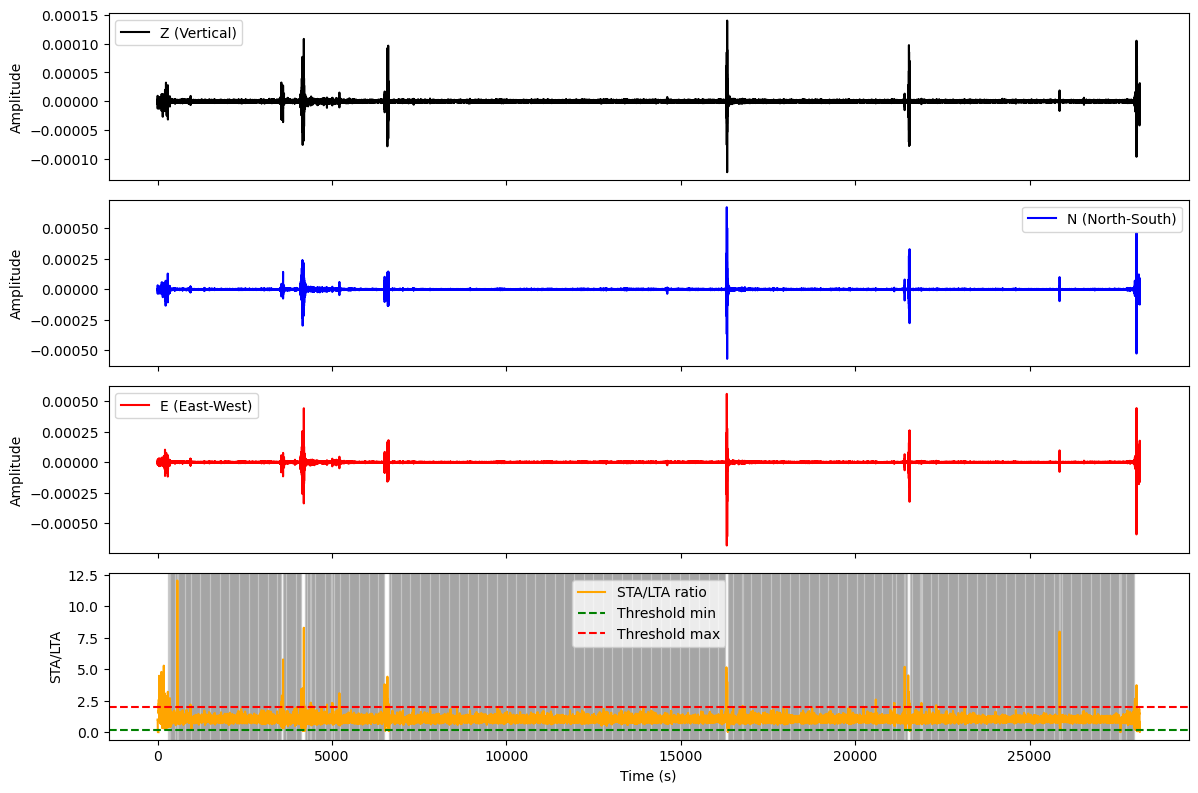

In [9]:
# === Visualización de resultados ===
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# 1. Componentes sísmicas
axs[0].plot(data_times, data[:, 0], label='Z (Vertical)', color='k')
axs[0].legend()
axs[0].set_ylabel("Amplitude")

axs[1].plot(data_times, data[:, 1], label='N (North-South)', color='b')
axs[1].legend()
axs[1].set_ylabel("Amplitude")

axs[2].plot(data_times, data[:, 2], label='E (East-West)', color='r')
axs[2].legend()
axs[2].set_ylabel("Amplitude")

# 2. Cociente STA/LTA
axs[3].plot(data_times[:len(lta_sta)], lta_sta, color='orange', label='STA/LTA ratio')
axs[3].axhline(seuilmin, color='g', linestyle='--', label='Threshold min')
axs[3].axhline(seuilmax, color='r', linestyle='--', label='Threshold max')

# 3. Marcar ventanas de activación (zonas sombreadas)
if len(fen) > 0:
    # Aseguramos que fen tenga forma (2, N)
    if fen.shape[0] == 2:
        fen = fen.T  # transponer si es necesario
    for start, end in fen:
        axs[3].axvspan(data_times[start], data_times[end-1], color='gray', alpha=0.3)

axs[3].legend()
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("STA/LTA")

plt.tight_layout()
plt.show()


### Cálculo de espectros H/V Y determinación del pico $𝑓_{0}$ 

---

**2. Preprocesamiento por ventana**

Para cada ventana $s_i(t)$:

**(a) Eliminación de la media**

$$ s_i(t) \leftarrow s_i(t) - \bar{s}_i $$

**(b) Aplicación de ventana de Hanning en 2% de los bordes**

$$ s_i(t) \leftarrow s_i(t) \, w(t) $$

donde $w(t)$ es la ventana tipo Hanning.

**(c) Zero-padding hasta longitud $L$**

$$ s_i(t) \rightarrow \tilde{s}_i(t), \qquad \text{con longitud } L = 2^{\lceil \log_2(L_W)\rceil} $$

---
**3. Transformada de Fourier**

Para cada componente $(\mathrm{NS}, \mathrm{EW}, \mathrm{V})$ se calcula:

$$ S_{i,k}(f) = \log_{10}\left( | \mathcal{F}\{ \tilde{s}_{i,k}(t)\} | \right) $$

El espectro se limita a $0 < f \le f_{\max}$.

---

**4. Suavizado espectral Konno–Ohmachi**

Cada espectro se somete al suavizado:

$$ \hat{S}_{i,k}(f) = 10^{ \text{KO}( S_{i,k}(f) ) } $$

donde $\text{KO}$ es el operador de suavizado Konno–Ohmachi.

---

**5. Cálculo del cociente H/V por ventana**

Primero se calcula la componente horizontal promedio:

$$ H_i(f) = \sqrt{ 
\frac{
\hat{S}_{i,\mathrm{NS}}(f)^2 + 
\hat{S}_{i,\mathrm{EW}}(f)^2
}{2}
} $$

Luego los cocientes:

**HV total**
$$ HV_i(f) = \log_{10}\left( \frac{H_i(f)}{\hat{S}_{i,\mathrm{V}}(f)} \right) $$

**HV por componentes**
$$ HV_{i,\mathrm{NS}}(f) = \log_{10}\left( \frac{\hat{S}_{i,\mathrm{NS}}(f)}{\hat{S}_{i,\mathrm{V}}(f)} \right) $$

$$ HV_{i,\mathrm{EW}}(f) = \log_{10}\left( \frac{\hat{S}_{i,\mathrm{EW}}(f)}{\hat{S}_{i,\mathrm{V}}(f)} \right) $$

---

**6. Promedio logarítmico entre ventanas**

El promedio final:

$$ HV_{\text{mean}}(f) = 10^{
\frac{1}{N_w}
\sum_{i=1}^{N_w} HV_i(f)
}
$$

La desviación estándar:

$$ \sigma(f) =
\sqrt{
\frac{1}{N_w - 1}
\sum_{i=1}^{N_w}
\left( HV_i(f) - \overline{HV}(f) \right)^2
} $$

y los límites:

$$ HV_{\text{low}}(f) = 10^{\overline{HV}(f) - \sigma(f)} $$

$$ HV_{\text{high}}(f) = 10^{\overline{HV}(f) + \sigma(f)} $$

---

**7. Estimación del pico fundamental**

El pico $A_0$ y su frecuencia $f_0$ se obtienen como:

$$ A_0 = \max_f HV_{\text{mean}}(f) $$

$$ f_0 = f \, | \, HV_{\text{mean}}(f) = A_0 $$

También se evalúan picos alternativos $f_{0,+}$ y $f_{0,-}$ según SESAME.

---

**8. Dispersión de los picos por ventana**

Para cada ventana:

$$ f_{0,i} = \arg\max_f HV_i(f) $$

Con promedio geométrico:

$$ f_{0,\text{mean}} = 10^{
\frac{1}{N_w}
\sum_{i=1}^{N_w} \log_{10}(f_{0,i})
} $$

Desviación estándar:

$$ \sigma_{f_0} =
\sqrt{
\frac{1}{N_w - 1}
\sum_{i=1}^{N_w}
\left( \log_{10}(f_{0,i}) - \log_{10}(f_{0,\text{mean}}) \right)^2
}
$$


In [28]:
 

def liskonno(f, fftcvert, fftcns, fftceo, lissvar):
    """
    Apply Konno-Ohmachi smoothing to equally spaced frequency data.

    Parameters
    - f: 1D np.ndarray of frequencies (Hz), equally spaced
    - fftcvert: 1D np.ndarray (log10 spectrum) for vertical (Z)
    - fftcns: 1D np.ndarray (log10 spectrum) for N component
    - fftceo: 1D np.ndarray (log10 spectrum) for E component
    - lissvar: Konno-Ohmachi b parameter

    Returns
    - lfftcvert: 2D np.ndarray of shape (len(f), 3) with smoothed log10 spectra [Z, N, E]
    """
    nt = len(fftcvert)
    lfftcvert = np.zeros((nt, 3), dtype=float)
    lfftcvert[0, 0] = fftcvert[0]
    lfftcvert[0, 1] = fftcns[0]
    lfftcvert[0, 2] = fftceo[0]

    # frequency ratio factor as in MATLAB: fratio = 10^(2.5/lissvar)
    fratio = 10.0 ** (2.5 / float(lissvar))

    for ix in range(2, nt + 1):
        ifc = ix - 1
        xl1 = max(int(np.ceil(ifc / fratio)), 1)
        xl2 = min(int(np.floor(ifc * fratio)), nt - 1)
        if xl2 >= nt - 1:
            xl2 = nt - 1
        # Build smoothing weights in log-frequency distance
        idx_range = np.arange(xl1, xl2 + 1)
        vliss = lissvar * np.log10(idx_range / float(ifc))
        # Apply Konno-Ohmachi kernel (sin(x)/x)^4, with center weight = 1
        left_len = max(ifc - xl1, 0)
        right_start = left_len + 2
        right_len = (xl2 - xl1 + 1) - (right_start - 1)
        if left_len > 0:
            vliss[:left_len] = (np.sin(vliss[:left_len]) / vliss[:left_len]) ** 4
        if right_len > 0:
            vliss[right_start - 1:right_start - 1 + right_len] = (
                np.sin(vliss[right_start - 1:right_start - 1 + right_len]) /
                vliss[right_start - 1:right_start - 1 + right_len]
            ) ** 4
        # center weight
        center_idx = left_len
        vliss[center_idx] = 1.0

        # Accumulate weighted sums (shift by +1 for MATLAB-style 1-based indices)
        sZ = np.sum(np.asarray(fftcvert[xl1:xl2 + 1]) * vliss)
        sN = np.sum(np.asarray(fftcns[xl1:xl2 + 1]) * vliss)
        sE = np.sum(np.asarray(fftceo[xl1:xl2 + 1]) * vliss)
        wsum = np.sum(vliss)
        lfftcvert[ix - 1, 0] = sZ / wsum
        lfftcvert[ix - 1, 1] = sN / wsum
        lfftcvert[ix - 1, 2] = sE / wsum

    return lfftcvert

In [11]:
 

def peakdet(v, delta, x=None):
    """
    Detect peaks in a vector.
    Returns (maxtab, mintab) where each is an array of [index/value] rows.
    If x is provided, indices are replaced with corresponding x-values.
    """
    v = np.asarray(v).flatten()
    if x is None:
        x = np.arange(1, len(v) + 1)
    else:
        x = np.asarray(x).flatten()
        if len(v) != len(x):
            raise ValueError("Input vectors v and x must have same length")
    if np.ndim(delta) != 0:
        raise ValueError("Input argument DELTA must be a scalar")
    if delta <= 0:
        raise ValueError("Input argument DELTA must be positive")

    mn = np.inf
    mx = -np.inf
    mnpos = np.nan
    mxpos = np.nan
    lookformax = True
    maxtab = []
    mintab = []

    for i in range(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append([mxpos, mx])
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append([mnpos, mn])
                mx = this
                mxpos = x[i]
                lookformax = True
    return np.array(maxtab), np.array(mintab)

# Pointage function: determine f0 and fmax using t-test criteria
def pointage_f0(BTF, std, fBTF, table, ns, AMP):
    """
    Python translation of MATLAB pointage_f0.
    Inputs:
    - BTF: 2D array (len(f) x 1 or more). Uses column 0.
    - std: 1D array of std in log10 domain (same length as fBTF).
    - fBTF: frequency vector (1D, Hz).
    - table: t-test table (2D array) as in MATLAB code.
    - ns: 1D array of sample counts per frequency bin.
    - AMP: amplitude at which t-test is performed.
    Returns: f0, A0, fmax, Amax
    """
    BTF = np.atleast_2d(BTF)
    a = np.isnan(BTF[:, 0])
    b = np.where(a == 0)[0]
    c = np.where(fBTF > 0.2)[0]
    if len(c) == 0:
        return 0.0, 0.0, 0.0, 0.0

    aTF = BTF[c[0]:, 0]
    f = fBTF[c[0]:]

    maxtab, mintab = peakdet(aTF, 0.5)
    if maxtab.size == 0:
        return 0.0, 0.0, 0.0, 0.0

    # Find global maximum among local maxima
    e = np.max(maxtab[:, 1])
    ff = int(np.argmax(maxtab[:, 1]))
    Amax = e
    fmax = f[int(maxtab[ff, 0]) - 1] if maxtab[ff, 0] > 1 else f[0]

    # t-test columns depending on ns
    if np.max(ns) > 1:
        alfa = 0.005
        colo = 6
    else:
        alfa = 0.025
        colo = 4

    g = maxtab.shape[0]
    if g < 2:
        f0 = f[int(maxtab[ff, 0]) - 1] if maxtab[ff, 0] > 1 else f[0]
        A0 = e
        return f0, A0, fmax, Amax

    # One-sample t-test on local maxima
    test2 = np.zeros(g, dtype=int)
    for n in range(g):
        idx = int(maxtab[n, 0]) - 1
        if idx < 0:
            idx = 0
        # Compute t-statistic
        denom = std[idx] / np.sqrt(ns[idx] + 1)
        if denom == 0:
            denom = np.finfo(float).eps
        testt = (np.log10(maxtab[n, 1]) - np.log10(AMP)) / denom
        # Threshold lookup
        if ns[idx] < 99:
            h = 1 if testt >= table[ns[idx] + 3, colo - 1] else 0
        else:
            h = 1 if testt >= table[101, colo - 1] else 0
        test2[n] = h
    # Select first maxima satisfying the test
    for n in range(g):
        if test2[n] == 1:
            idx = int(maxtab[n, 0]) - 1
            idx = max(idx, 0)
            f0 = f[idx]
            A0 = maxtab[n, 1]
            return f0, A0, fmax, Amax
    # No valid peak
    return 0.0, 0.0, fmax, Amax

In [ ]:
 

def calculHV(Data, fen, tvar, lis_typ, lis_var, Fs, fsensor, fmax,
             table=None, pointage_fn=None, plot=True):
    """
    Same as your function, only adding visualization.
    """

    fen = np.array(fen)
    if fen.shape[0] != 2 and fen.shape[1] == 2:
        fen = fen.T
    o, nbf = fen.shape
    nt, nbsens = Data.shape

    lf2 = []
    for i in range(nbf):
        lf = fen[1, i] - fen[0, i]
        lf2.append(1 << (int(np.ceil(np.log2(max(lf, 1))))))
    L = int(max(lf2))

    df = Fs / L
    nyquist = Fs / 2

    if fmax <= nyquist:
        f = np.arange(df, fmax, df)
    else:
        f = np.arange(df, nyquist, df)

    c_idx = np.where(f >= fsensor)[0]
    c_start = int(c_idx[0]) if len(c_idx) > 0 else 0

    fft1 = np.zeros((len(f), nbsens, nbf))

    # --- PREPROCESSING + FFT ---
    if plot:
        plt.figure(figsize=(10, 4))
        plt.title("Preprocesamiento de ventanas (ejemplo de la primera ventana)")
    
    for i in range(nbf):
        for j in range(nbsens):
            s = Data[fen[0,i]:fen[1,i], j].astype(float)
            s = s - np.mean(s)  # 2.1 Eliminar la media

            # Ventana de Hanning (2%)
            ws = windows.hann(len(s))
            nw = int(0.02 * len(s))
            if nw > 0:
                s[:nw] *= ws[:nw]
                s[-nw:] *= ws[-nw:]

            # Plot preprocessing (solo ventana 1)
            if plot and i == 0 and j == 0:
                plt.plot(s, label="s(t) tras preprocesamiento")
                plt.legend()
                plt.xlabel("Muestras")
                plt.ylabel("Amplitud")

            # Zero-padding
            if len(s) < L:
                s = np.pad(s, (0, L - len(s)), 'constant')

            # FFT
            spec = np.log10(np.abs(np.fft.fft(s, n=L)) + np.finfo(float).eps)
            fft1[:, j, i] = spec[:len(f)]

    if plot:
        plt.show()

    # --- SUAVIZADO ---
    if lis_typ == 1:
        if 'liskonno' not in globals():
            raise NameError("liskonno function not found.")
        fft_l = np.zeros((len(f), nbsens, nbf))
        for i in range(nbf):
            sm = liskonno(f, fft1[:,0,i], fft1[:,1,i], fft1[:,2,i], lis_var)
            fft_l[:, :, i] = 10**sm
    else:
        fft_l = 10**fft1

    # Plot smoother example
    if plot:
        plt.figure(figsize=(10,4))
        plt.title("Espectro suavizado vs original (ventana 1 - vertical)")
        plt.plot(f, fft1[:,0,0], alpha=0.4, label="Original log10")
        plt.plot(f, np.log10(fft_l[:,0,0]), label="Suavizado")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Amplitud (log10)")
        plt.legend()
        plt.show()

    # --- H/V RATIO ---
    rho = np.sqrt((fft_l[:,1,:]**2 + fft_l[:,2,:]**2) / 2)
    HV = np.log10(rho / (fft_l[:,0,:] + 1e-12))

    # I - FFT of each window
    # fft1: reduced to len(f); fft2: full log10(abs(fft)) up to L
    fft1 = np.zeros((len(f), nbsens, nbf), dtype=float)

    for i in range(nbf):
        for j in range(nbsens):
            s = Data[fen[0, i]:fen[1, i], j].astype(float)
            s = s - np.mean(s)
            ws = windows.hann(len(s))
            nw = int(np.floor(0.02 * len(s)))
            if nw > 0:
                s[:nw] *= ws[:nw]
                s[-nw:] *= ws[-nw:]
            # zero-pad to L
            if len(s) < L:
                s = np.pad(s, (0, L - len(s)), mode='constant')
            # FFT and reduce to frequencies vector length
            spec = np.log10(np.abs(fft(s, n=L)) + np.finfo(float).eps)
            fft1[:, j, i] = spec[:len(f)]

    # II - Smoothing of FFTs for each window
    # Expect liskonno(f, Z, N, E, b) to return log10-smoothed spectra stacked as columns
    if lis_typ == 1:
        fft_l = np.zeros((len(f), nbsens, nbf), dtype=float)
        for i in range(nbf):
            # liskonno should return log10 values for each component
            if 'liskonno' not in globals():
                raise NameError("liskonno function not found. Please define/import it.")
            sm = liskonno(f, fft1[:, 0, i], fft1[:, 1, i], fft1[:, 2, i], lis_var)
            # Convert back from log10 to linear as in MATLAB code
            fft_l[:, :, i] = 10.0 ** sm
    else:
        # No smoothing; convert from log10 to linear
        fft_l = 10.0 ** fft1

    # III - H/V ratios per window (using RMS of horizontals)
    rho = np.sqrt((fft_l[:, 1, :] ** 2 + fft_l[:, 2, :] ** 2) / 2.0)
    HVns = np.log10(fft_l[:, 1, :] / (fft_l[:, 0, :] + np.finfo(float).eps))
    HVeo = np.log10(fft_l[:, 2, :] / (fft_l[:, 0, :] + np.finfo(float).eps))
    HV = np.log10(rho / (fft_l[:, 0, :] + np.finfo(float).eps))

    # IV - Means and standard deviations (log domain)
    HV_mean_log = np.mean(HV, axis=1)
    HV_mean_logns = np.mean(HVns, axis=1)
    HV_mean_logeo = np.mean(HVeo, axis=1)

    HVmean = 10.0 ** HV_mean_log
    HVmeanns = 10.0 ** HV_mean_logns
    HVmeaneo = 10.0 ** HV_mean_logeo

    HV_sig = np.sqrt(np.sum((HV - HV_mean_log[:, None]) ** 2, axis=1) / (nbf - 1))
    HV_signs = np.sqrt(np.sum((HVns - HV_mean_logns[:, None]) ** 2, axis=1) / (nbf - 1))
    HV_sigeo = np.sqrt(np.sum((HVeo - HV_mean_logeo[:, None]) ** 2, axis=1) / (nbf - 1))

    HV_up = 10.0 ** (HV_mean_log + HV_sig)
    HV_upns = 10.0 ** (HV_mean_logns + HV_signs)
    HV_upeo = 10.0 ** (HV_mean_logeo + HV_sigeo)

    HV_lo = 10.0 ** (HV_mean_log - HV_sig)
    HV_lons = 10.0 ** (HV_mean_logns - HV_signs)
    HV_loeo = 10.0 ** (HV_mean_logeo - HV_sigeo)

    # Result matrix
    HV_data = np.zeros((len(f), 10), dtype=float)
    HV_data[:, 0] = f
    HV_data[:, 1] = HVmean
    HV_data[:, 2] = HV_lo
    HV_data[:, 3] = HV_up
    HV_data[:, 4] = HVmeanns
    HV_data[:, 5] = HV_lons
    HV_data[:, 6] = HV_upns
    HV_data[:, 7] = HVmeaneo
    HV_data[:, 8] = HV_loeo
    HV_data[:, 9] = HV_upeo

    # Peak search on mean H/V curve, restricted to f >= fsensor
    nf = len(f)
    search_start = c_start + int(round(0.05 / df))
    search_start = min(search_start, nf - 1)

    A0 = np.zeros(3, dtype=float)
    z = np.zeros(3, dtype=int)

    A0[0] = np.max(HVmean[search_start:])
    z[0] = int(np.argmax(HVmean[search_start:])) + search_start

    # define local window around z[0]
    low = c_start + int(round(0.9 * z[0]))
    high = c_start + int(round(1.1 * z[0]))
    low = max(low, 0)
    high = min(high, nf - 1)

    A0[1] = np.max(HV_lo[low:high + 1])
    z[1] = int(np.argmax(HV_lo[low:high + 1])) + low

    A0[2] = np.max(HV_up[low:high + 1])
    z[2] = int(np.argmax(HV_up[low:high + 1])) + low

    f0 = np.zeros(3, dtype=float)
    f0[0] = f[z[0]]
    f0[1] = f[z[1]]
    f0[2] = f[z[2]]

    # Optional: pointage_f0_std
    f01 = f02 = A01 = A02 = None
    f0std1 = None
    if pointage_fn is not None and table is not None:
        # pointage_fn expects: 10**HV_mean_log, HV_sig, f, table, nbf*ones(len(f)), 2
        nbf_arr = np.full(len(f), nbf, dtype=int)
        f01, A01, f02, A02 = pointage_fn(10.0 ** HV_mean_log, HV_sig, f, table, nbf_arr, 2)
    else:
        # Fallback: choose primary and secondary peaks as max and second max
        # within the search band
        band = slice(search_start, nf)
        hv_band = HVmean[band]
        idx_sorted = np.argsort(hv_band)[::-1]
        if len(idx_sorted) >= 1:
            f01 = f[search_start + idx_sorted[0]]
            A01 = hv_band[idx_sorted[0]]
        if len(idx_sorted) >= 2:
            f02 = f[search_start + idx_sorted[1]]
            A02 = hv_band[idx_sorted[1]]

    # Peak per window around f01
    f0w1 = []
    A0w1 = []
    if f01 is not None:
        start_idx = z[0] - int(round((0.2 * f01) / df))
        start_idx = max(start_idx, 0)
        for i in range(nbf):
            band = HV[start_idx:nf, i]
            I = int(np.argmax(band))
            a = start_idx + I
            a = min(a, nf - 1)
            f0w1.append(f[a])
            A0w1.append(band[I])

    # Peak per window around f02
    f0w2 = []
    A0w2 = []
    if f02 is not None:
        start_idx = z[0] - int(round((0.2 * f02) / df))
        start_idx = max(start_idx, 0)
        for i in range(nbf):
            band = HV[start_idx:nf, i]
            I = int(np.argmax(band))
            a = start_idx + I
            a = min(a, nf - 1)
            f0w2.append(f[a])
            A0w2.append(band[I])

    # Means and std of window peaks (log domain)
    f0mean1 = None
    f0mean2 = None
    if len(f0w1) > 0:
        f0mean1_log = np.mean(np.log10(np.asarray(f0w1)))
        f0mean1 = 10.0 ** f0mean1_log
        f0std1 = np.std(np.log10(np.asarray(f0w1)))
    if len(f0w2) > 0:
        f0mean2_log = np.mean(np.log10(np.asarray(f0w2)))
        f0mean2 = 10.0 ** f0mean2_log
        # original code computes f0std2 but not returned; we keep alignment
        # f0std2 = np.std(np.log10(np.asarray(f0w2)))

    return (HV_data, f0, A0, f0mean1, f0mean2, HV,
            np.asarray(f0w1), np.asarray(A0w1), np.asarray(f0w2), np.asarray(A0w2),
            f01, A01, f02, A02, f0std1)


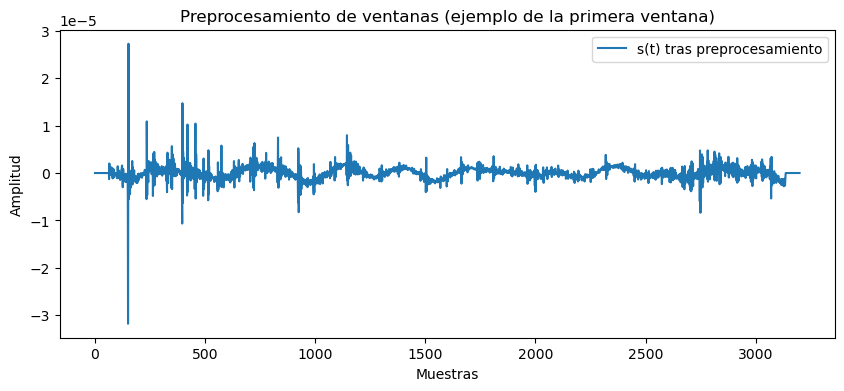

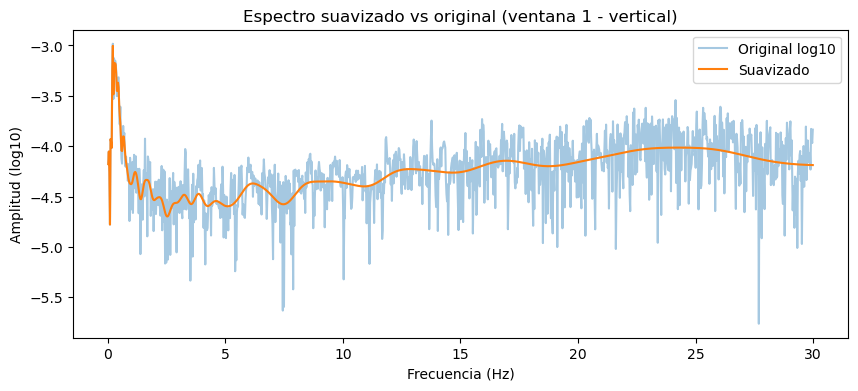

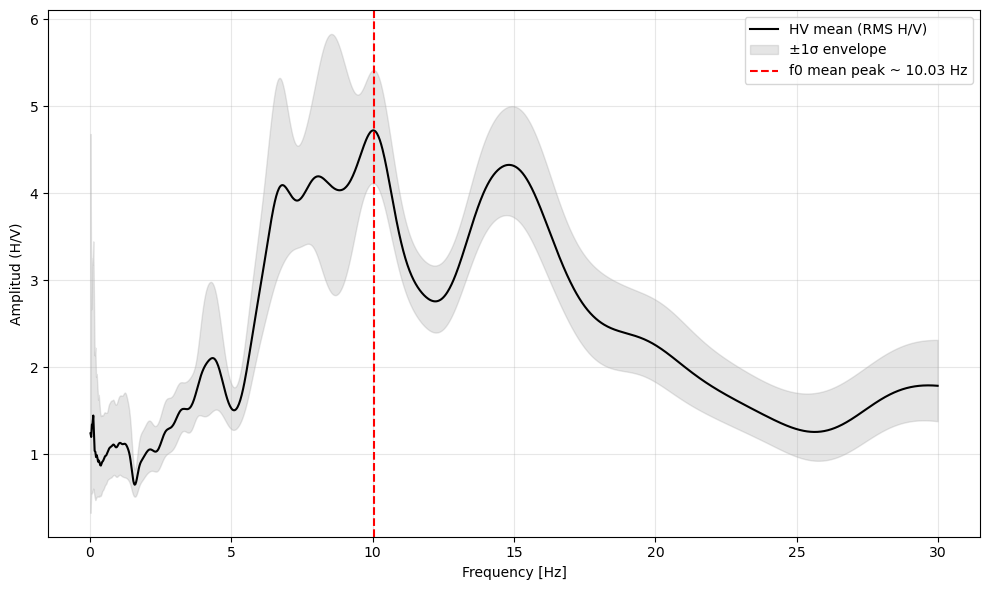

f0 peaks: [10.03417969 10.00976562 10.03417969]
A0 amplitudes: [4.72280234 4.1173704  5.41843795]


In [27]:


# Load t-test table if available (replace with actual path/format)
# For now, create a placeholder table compatible with indexing used in pointage_f0
# Columns: we need at least 6 columns; rows up to index 101
try:
     
    # Try reading an Excel file named 'ttest-table.xls' in workspace root
    table_path = 'ttest-table.xls'
    ttest_df = pd.read_excel(table_path, header=None)
    ttest_table = ttest_df.values
except Exception:
    # Fallback synthetic thresholds (not scientific, for code continuity)
    ttest_table = np.zeros((102, 6), dtype=float)
    # Set modest thresholds to avoid false zeros
    ttest_table[:, 3] = 1.96  # approx t for 95%
    ttest_table[:, 5] = 2.58  # approx t for 99%

# Ensure fen is shape (2, nbf)
fen_arr = np.array(fen)
if fen_arr.shape[0] != 2 and fen_arr.shape[1] == 2:
    fen_arr = fen_arr.T

HV_data, f0, A0, f0mean1, f0mean2, HV, f0w1, A0w1, f0w2, A0w2, f01, A01, f02, A02, f0_sig = calculHV(
    Data=data,
    fen=fen_arr,
    tvar=tvar,
    lis_typ=1,
    lis_var=40,
    Fs=fs,
    fsensor=0.5,
    fmax=30.0,
    table=ttest_table,
    pointage_fn=pointage_f0
)

# Plot HV mean with envelopes and mark peaks
f = HV_data[:, 0]
HVmean = HV_data[:, 1]
HV_lo = HV_data[:, 2]
HV_up = HV_data[:, 3]

plt.figure(figsize=(10, 6))
plt.plot(f, HVmean, 'k-', label='HV mean (RMS H/V)')
plt.fill_between(f, HV_lo, HV_up, color='gray', alpha=0.2, label='±1σ envelope')

# Mark f0 peaks
plt.axvline(f0[0], color='r', linestyle='--', label=f'f0 mean peak ~ {f0[0]:.2f} Hz')
 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitud (H/V)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('f0 peaks:', f0)
print('A0 amplitudes:', A0)


###  Criterios SESAME 

Site Effects Safety Assessment using Microtremors

**Criterio 1: Resolución suficiente en frecuencia**

$ f_0 > \frac{10}{LW} $

La ventana debe ser lo suficientemente larga para resolver adecuadamente el pico.

**Criterio 2: Estabilidad estadística del pico**

$ NW \cdot LW \cdot f_0 > 200 $

Debe existir suficiente duración total registrada para garantizar estabilidad en la estimación del pico H/V.

**Criterio 3: Estabilidad del espectro alrededor del pico**

Para todas las frecuencias $ f $ tales que $ 0.5 f_0 < f < 2 f_0 $:

$ \text{std}(f) < 2 $

La desviación estándar logarítmica del H/V no debe superar 2 en el rango alrededor del pico.

**Criterio 4: Caída del espectro por debajo del pico (lado izquierdo)**

Para todas las frecuencias $ f $ tales que $ 0.25 f_0 < f < f_0 $:

$ HV(f) < \frac{A_0}{2} $

La amplitud debe caer al menos a la mitad antes de llegar al pico.

**Criterio 5: Caída del espectro por encima del pico (lado derecho)**

Para todas las frecuencias $ f $ tales que $ f_0 < f < 4 f_0 $:

$ HV(f) < \frac{A_0}{2} $

El decaimiento después del pico también debe ser suficiente.

**Criterio 6: Amplitud mínima del pico**

$ A_0 > 2 $

El pico debe ser suficientemente marcado para ser confiable.

**Criterio 7: Consistencia entre estimaciones del pico**

$ 0.95 f_0 \le f_{0,+} \le 1.05 f_0 \quad \text{y} \quad 0.95 f_0 \le f_{0,-} \le 1.05 f_0 $

Las estimaciones del pico utilizando $A_0+$ y $A_0-$ deben ser coherentes con la frecuencia principal $f_0$.

**Criterio 8: Dispersión aceptable entre ventanas**

$ \sigma_{f_0} < \epsilon $

Donde $\epsilon$ depende del valor de $f_0$:

Si $0.2 < f_0 \le 0.5$, entonces $\epsilon = 0.2 f_0$

Si $0.5 < f_0 \le 1$, entonces $\epsilon = 0.15 f_0$

Si $1 < f_0 \le 2$, entonces $\epsilon = 0.1 f_0$

Si $f_0 > 2$, entonces $\epsilon = 0.05 f_0$

**Criterio 9: Estabilidad local alrededor del pico**

$ \text{std}(f \in [f_0 - df, , f_0 + df]) < \theta $

Donde $\theta$ depende del valor de $f_0$:

Si $0.2 < f_0 \le 0.5$, entonces $\theta = 2.5$

Si $0.5 < f_0 \le 1$, entonces $\theta = 2$

Si $1 < f_0 \le 2$, entonces $\theta = 1.78$

Si $f_0 > 2$, entonces $\theta = 1.58$


In [ ]:

def crit_SESAM(HV_data, fen, tmin, f0, A0, f0_sig, fsensor):
    """
    Traducción del script MATLAB 'crit_SESAM.m' para verificar
    los criterios SESAME de fiabilidad del H/V.

    Parameters
    ----------
    HV_data : array (N,4)
        Columna 0: frecuencia
        Columna 1: HV_mean
        Columna 2: HV_lo
        Columna 3: HV_up
    fen : array
        Ventanas (2 x nwindows)
    tmin : float
        Longitud de ventana (s)
    f0 : array
        [f02, f0_plus, f0_minus]
    A0 : array
        [A02, A0_plus, A0_minus]
    f0_sig : float
        Desviación estándar de la frecuencia del pico
    fsensor : float
        Frecuencia del sensor

    Returns
    -------
    crit : array de 9 valores (0 o 1)
        Criterios SESAME 1 a 9
    """

    print("Verificando criterio SESAME...")

    lw = tmin
    _, nw = fen.shape  # número de ventanas

    f      = HV_data[:, 0]
    HVmean = HV_data[:, 1]
    HV_lo  = HV_data[:, 2]
    HV_up  = HV_data[:, 3]

    std = np.log10(HV_up / HVmean)
    df  = abs(f[1] - f[0])

    # Parámetros del pico
    A02  = A0[0]
    f02  = f0[0]
    stdf = f0_sig

    # Índices alrededor del pico
    n0 = np.where((f02 - df < f) & (f < f02 + df))[0]

    # Criterios umbral E y teta
    E = np.array([0.2*f02, 0.15*f02, 0.1*f02, 0.05*f02])
    teta = np.array([2.5, 2.0, 1.78, 1.58])

    crit = np.zeros(9, dtype=int)

    # --- Criterio 1 ---
    crit[0] = int(f02 > 10 / lw)

    # --- Criterio 2 ---
    crit[1] = int(nw * lw * f02 > 200)

    # --- Criterio 3 ---
    I = np.where((0.5*f02 < f) & (f < 2*f02))[0]
    crit[2] = int(np.all(std[I] < 2))

    # --- Criterio 4 ---
    I = np.where((0.25*f02 < f) & (f < f02))[0]
    crit[3] = int(np.any(HVmean[I] < A02/2))

    # --- Criterio 5 ---
    J = np.where((f02 < f) & (f < 4*f02))[0]
    crit[4] = int(np.any(HVmean[J] < A02/2))

    # --- Criterio 6 ---
    crit[5] = int(A02 > 2)

    # --- Criterio 7 ---
    f0pl, f0mo = f0[1], f0[2]

    cond7 = (
        (f02*0.95 <= f0pl <= f02*1.05) and
        (f02*0.95 <= f0mo <= f02*1.05)
    )

    crit[6] = int(cond7)

    # --- Criterios 8 y 9 ---
    if 0.2 < f02 <= 0.5:
        k = 0
    elif 0.5 < f02 <= 1:
        k = 1
    elif 1 < f02 <= 2:
        k = 2
    else:  # f02 > 2
        k = 3

    crit[8] = int( std[n0].mean() < teta[k] )
    crit[7] = int( stdf < E[k] )

    return crit




In [16]:
crit=crit_SESAM(HV_data, fen, tmin, f0, A0, f0_sig,fsensor)

print("Criterios SESAME (1-9):", crit)

Verificando criterio SESAME...
Criterios SESAME (1-9): [1 1 1 1 1 1 1 1 1]
